In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import (
            confusion_matrix, classification_report,
            PrecisionRecallDisplay, precision_recall_curve,
            average_precision_score,accuracy_score)

In [3]:
df = pd.read_csv("creditcard.csv")

### EDA

In [4]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
# Checking the size of the dataset
print(f"Shape of Dataset: {df.shape}")

# Checking for missing values
print("Max no. of Null Values:", df.isnull().sum().max())

# Checking the number of positive and negative samples
print("\n", df['Class'].value_counts())

Shape of Dataset: (284807, 31)
Max no. of Null Values: 0

 Class
0    284315
1       492
Name: count, dtype: int64


In [6]:
def visualize(df):
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(
        'Fraud Detection Dataset – Exploratory Data Analysis',
        fontsize=18,
        fontweight='bold'
    )

    # -----------------------------
    # 1. Class Distribution
    # -----------------------------
    sns.countplot(
        x='Class',
        data=df,
        palette='viridis',
        ax=axes[0, 0]
    )
    axes[0, 0].set_title('Transaction Class Distribution')
    axes[0, 0].set_xlabel('Class (0: Legitimate, 1: Fraud)')
    axes[0, 0].set_ylabel('Number of Transactions')

    # -----------------------------
    # 2. Fraudulent Transactions Amount
    # -----------------------------
    axes[0, 1].hist(
        df.Amount[df.Class == 1],
        bins=30,
        alpha=0.7,
        label='Fraud',
        color='red'
    )
    axes[0, 1].set_title('Fraudulent Transactions Amount')
    axes[0, 1].set_xlabel('Amount ($)')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].legend()

    # -----------------------------
    # 3. Legitimate Transactions Amount
    # -----------------------------
    axes[1, 0].hist(
        df.Amount[df.Class == 0],
        bins=30,
        alpha=0.7,
        label='Legitimate',
        color='blue'
    )
    axes[1, 0].set_title('Legitimate Transactions Amount')
    axes[1, 0].set_xlabel('Amount ($)')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_yscale('log')  # log scale due to imbalance
    axes[1, 0].legend()

    # -----------------------------
    # 4. Correlation Heatmap
    # -----------------------------
    corr = df.corr()
    sns.heatmap(
        corr,
        cmap='coolwarm_r',
        annot=False,
        ax=axes[1, 1]
    )
    axes[1, 1].set_title('Feature Correlation Heatmap')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


C:\Users\alire\AppData\Local\Temp\ipykernel_22996\2681794171.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


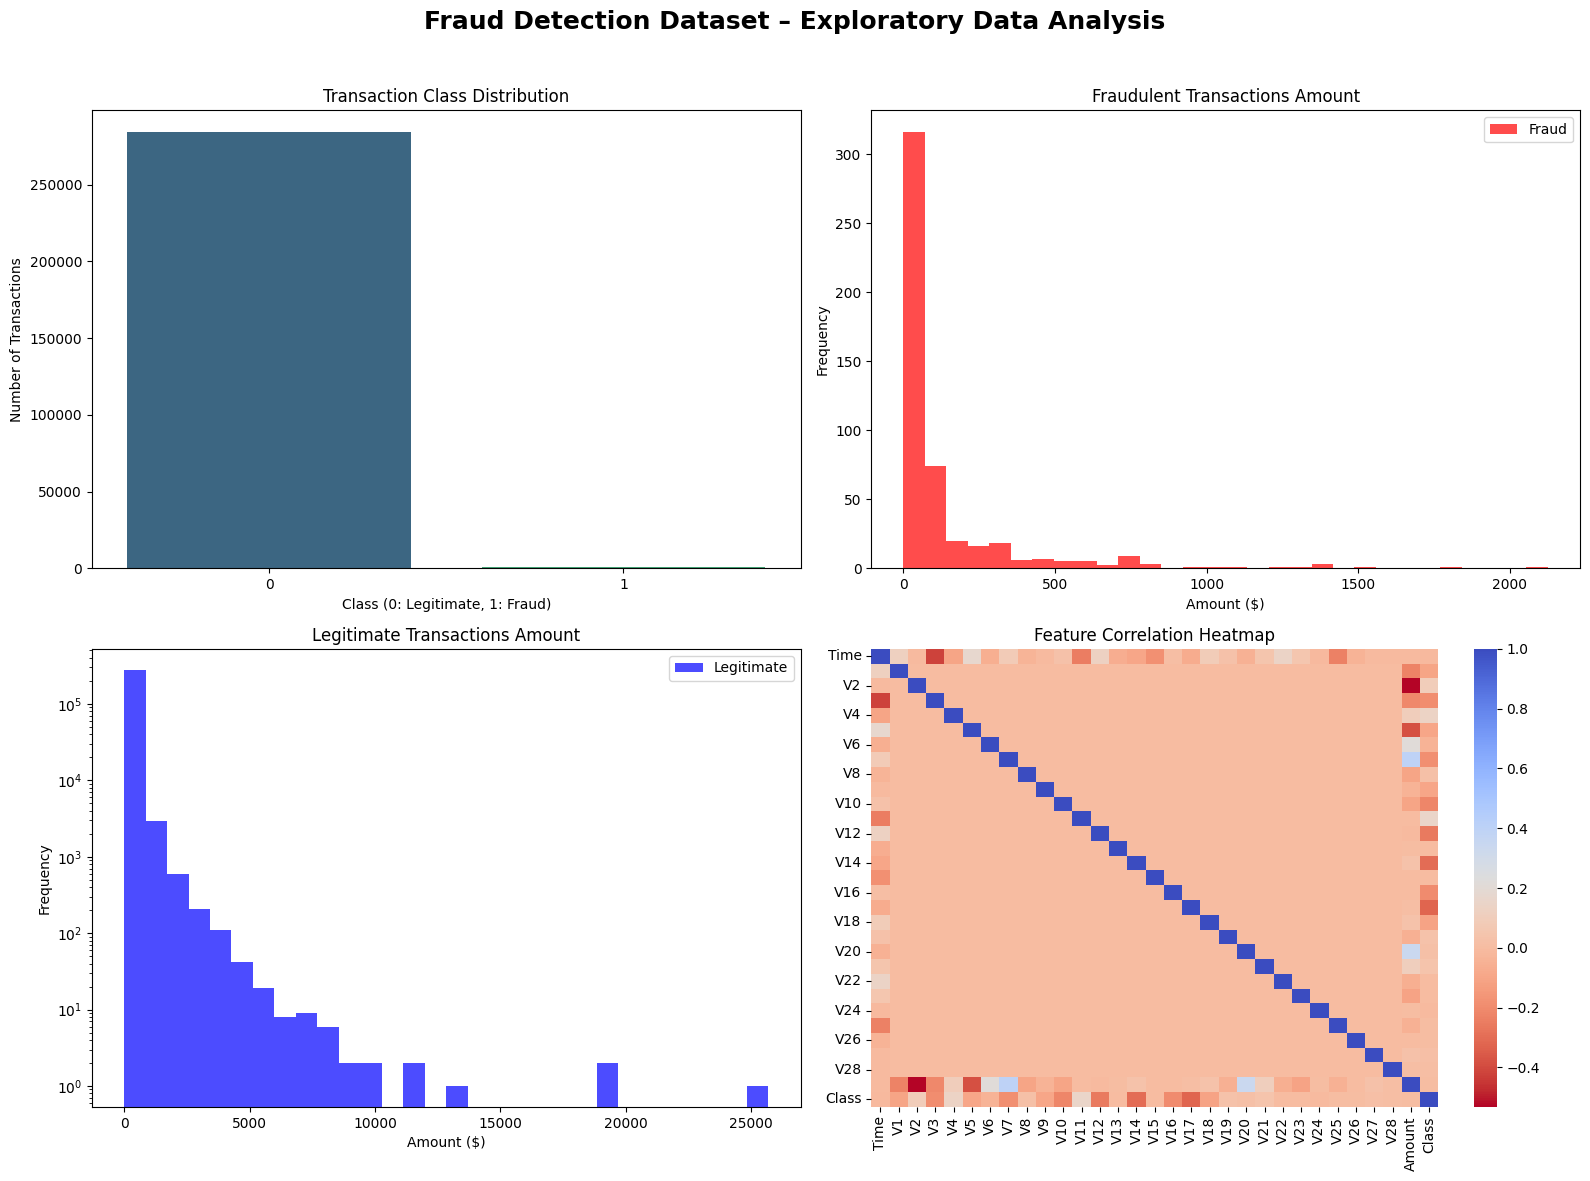

In [7]:
visualize(df)

### Preprocessing

In [8]:
def feature_scaling(df):
    # Create a Scaler Object (This shifts the data so the mean is 0 and standard deviation is 1)
    scaler = StandardScaler()

    # Scale 'Amount' and 'Time' (reshape is needed because scaler expects a 2D array)
    df['scaled_amount'] = scaler.fit_transform(df['Amount'].values.reshape(-1, 1))
    df['scaled_time'] = scaler.fit_transform(df['Time'].values.reshape(-1, 1))

    # Now we drop the original 'Time' and 'Amount' columns as they are redundant
    df.drop(['Time', 'Amount'], axis=1, inplace=True)


In [9]:
feature_scaling(df)

### TRaining

In [10]:
# X = all columns except 'Class'
X = df.drop('Class', axis=1)

# y = only the 'Class' column
y = df['Class']

In [11]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
X_train.describe()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,scaled_amount,scaled_time
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,0.000916,-0.000384,-0.000920,-0.001458,0.000997,-0.000613,0.001090,-0.000383,0.000961,-0.001250,...,0.000215,-0.001215,0.000175,-0.000217,-0.000979,-0.000192,-0.000032,0.000257,0.000521,-0.000449
std,1.958337,1.656602,1.514545,1.415853,1.387667,1.336803,1.243493,1.188643,1.097553,1.086659,...,0.732617,0.725311,0.627103,0.605446,0.521764,0.482443,0.401821,0.329776,1.019233,1.000009
min,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.320155,-24.588262,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-9.895244,-15.430084,-0.353229,-1.996583
25%,-0.919918,-0.597971,-0.890786,-0.849270,-0.688802,-0.768573,-0.552156,-0.208431,-0.642386,-0.536120,...,-0.228730,-0.542809,-0.161296,-0.354887,-0.317835,-0.327476,-0.070960,-0.052980,-0.330840,-0.856065
50%,0.017978,0.066050,0.179041,-0.020959,-0.054711,-0.274846,0.041272,0.022233,-0.050414,-0.094026,...,-0.029639,0.005491,-0.010595,0.040766,0.015101,-0.052011,0.001359,0.011366,-0.265271,-0.212829
75%,1.315548,0.803898,1.025399,0.741630,0.611173,0.396056,0.570639,0.327504,0.599040,0.450669,...,0.186080,0.527408,0.148202,0.439790,0.350453,0.240813,0.091400,0.078464,-0.044977,0.936891
max,2.454930,22.057729,4.187811,16.875344,34.801666,73.301626,120.589494,20.007208,10.392889,15.245686,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,102.362243,1.642058


In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [15]:
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]


### Models
- Decision Tree
- Random Forest
- XGBoost
- Logistic Regression

In [21]:
# initialize the models
models = {
    'Logistic Regression': LogisticRegression(
                            max_iter=1000,
                            random_state=42,
                            solver='lbfgs'
                            ),
    'Random Forest': RandomForestClassifier(n_estimators=100, max_depth=5, random_state=17,  class_weight='balanced', n_jobs=-1),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=17),
    'Gradient Boosting': XGBClassifier(
                        n_estimators=300,
                        max_depth=5,
                        learning_rate=0.05,
                        subsample=0.8,
                        colsample_bytree=0.8,
                        objective='binary:logistic',
                        scale_pos_weight=scale_pos_weight,
                        eval_metric='auc',
                        random_state=42
                    )
}


In [23]:
trained_models = {}
y_preds = {}
y_scores = {}

for name, model in models.items():
    print(f"\n{'='*40}")
    print(f"Training {name}")
    

    # Logistic Regression → use scaled data
    if name == "Logistic Regression":
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_score = model.predict_proba(X_test_scaled)[:, 1]

    # Tree-based models → use original data
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_score = model.predict_proba(X_test)[:, 1]

    # Store results
    y_preds[name] = y_pred
    y_scores[name] = y_score
    trained_models[name] = model

    # ✅ Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy of {name}: {acc:.4f}")
    print(f"{'='*40}")



Training Logistic Regression
Accuracy of Logistic Regression: 0.9991

Training Random Forest
Accuracy of Random Forest: 0.9975

Training Decision Tree
Accuracy of Decision Tree: 0.9995

Training Gradient Boosting
Accuracy of Gradient Boosting: 0.9995


In [24]:
for name in models.keys():
    print(f"\n{'-'*30}")
    print(f"{name} Evaluation")
    print(f"{'-'*30}")

    print("\nConfusion Matrix:")
    print(confusion_matrix(y_test, y_preds[name]))

    print("\nClassification Report:")
    print(classification_report(y_test, y_preds[name]))



------------------------------
Logistic Regression Evaluation
------------------------------

Confusion Matrix:
[[56854    10]
 [   43    55]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.56      0.67        98

    accuracy                           1.00     56962
   macro avg       0.92      0.78      0.84     56962
weighted avg       1.00      1.00      1.00     56962


------------------------------
Random Forest Evaluation
------------------------------

Confusion Matrix:
[[56734   130]
 [   11    87]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.40      0.89      0.55        98

    accuracy                           1.00     56962
   macro avg       0.70      0.94      0.78     56962
weighted avg       1.00      1.00      1.00     56962


---------------

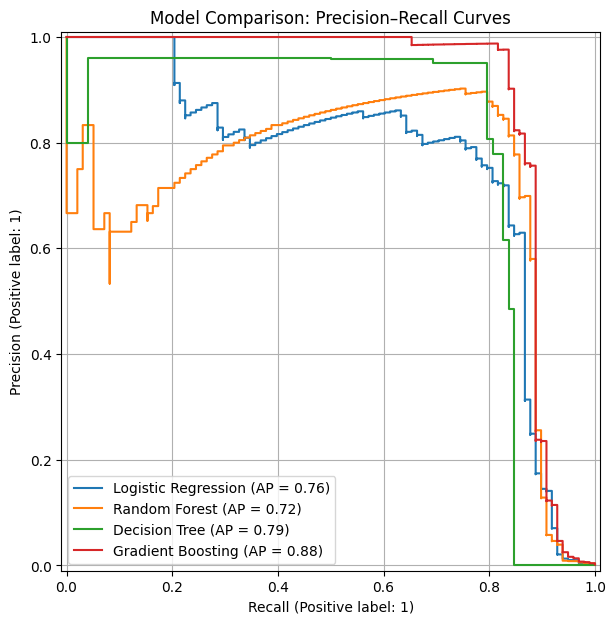

In [25]:
fig, ax = plt.subplots(figsize=(10, 7))

for name in models.keys():
    PrecisionRecallDisplay.from_predictions(
        y_test,
        y_scores[name],
        name=name,
        ax=ax
    )

ax.set_title("Model Comparison: Precision–Recall Curves")
plt.legend()
plt.grid(True)
plt.show()
